In [15]:
import numpy as np
import pandas as pd
import os
import math
from matplotlib import style
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from numpy import array
from sklearn.metrics import accuracy_score
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import random
import warnings
warnings.filterwarnings("ignore")
from itertools import chain
from sklearn.model_selection import train_test_split
    
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [29]:
def calculate_performances(pred,y_valx):
    y_pred= pd.DataFrame(pred, columns = ['ECoord', 'NCoord','FloorID'])
    y_pred['FloorID']= y_pred['FloorID'].round()

    count=0
    floor_dist=[0 for i in range(len(pred))]
    for i in range(0,len(y_pred)):
        if abs(y_pred.FloorID.loc[i])==abs(y_valx.FloorID.loc[i]):
            count=count+1
            floor_dist[i]=1
            
    #print('Floor accuracy', count/len(pred))

    accx=count/len(pred)
    accy=accx
    
    del y_pred['FloorID']
    del y_valx['FloorID']


    afsx= mean_absolute_error(y_valx, y_pred)+ (((len(pred)-count)*4)/len(pred))
    maex=mean_absolute_error(y_valx, y_pred)
    
    
    predicted_values = np.array(y_valx)
    ground_truth_values = np.array(y_pred)
    
    tempp= np.linalg.norm(predicted_values- ground_truth_values, axis=1)
    
    # Calculate the average localization error
    average_le = np.mean(tempp)
    

    
    squared_differences = (predicted_values- ground_truth_values) ** 2
    
    # Calculate the mean of the squared differences
    mean_squared_error = np.mean(squared_differences)
    
    # Calculate the root of the mean squared error
    rmsex2 = np.sqrt(mean_squared_error)
    
    

    final_dist=[0 for i in range(len(pred))]
    for i in range(0,len(floor_dist)):
        final_dist[i]=(abs(y_pred['ECoord'].loc[i]-y_valx['ECoord'].loc[i])+abs(y_pred['NCoord'].loc[i]-y_valx['NCoord'].loc[i]))/2
        if floor_dist[i]==0:
            final_dist[i]=final_dist[i]+4
    

    final_dist.sort()
   
    #ldistx=final_dist
    
    perc_pos=math.floor((50/100)*(len(final_dist)))

    if perc_pos>math.floor((50/100)*(len(final_dist))):
        error50=final_dist[perc_pos] + (final_dist[perc_pos+1]-final_dist[perc_pos])*0.5
    else:
        error50=final_dist[perc_pos]


    perc_pos=math.floor((75/100)*(len(final_dist)))

    if perc_pos>math.floor((75/100)*(len(final_dist))):
        error75=final_dist[perc_pos] + (final_dist[perc_pos+1]-final_dist[perc_pos])*0.5
    else:
        error75=final_dist[perc_pos]
        
    
    perc_pos=math.floor((95/100)*(len(final_dist)))

    if perc_pos>math.floor((95/100)*(len(final_dist))):
        error95=final_dist[perc_pos] + (final_dist[perc_pos+1]-final_dist[perc_pos])*0.5
    else:
        error95=final_dist[perc_pos]
    
    
    for i in range(0,len(final_dist)):
        final_dist[i]=pow(final_dist[i],2)

    from math import sqrt
    rmsex=sqrt(np.mean(final_dist)/2)
    
    
   
 
    #rmsex2=sqrt(mean_squared_error(y_valx, y_pred))

    
    final_dist=[0 for i in range(len(pred))]
    for i in range(0,len(floor_dist)):
        final_dist[i]=(abs(y_pred['ECoord'].loc[i]-y_valx['ECoord'].loc[i])+abs(y_pred['NCoord'].loc[i]-y_valx['NCoord'].loc[i]))/2
    
    final_dist.sort()
   
    #ldistx=final_dist
    
    perc_pos=math.floor((50/100)*(len(final_dist)))

    if perc_pos>math.floor((50/100)*(len(final_dist))):
        error502=final_dist[perc_pos] + (final_dist[perc_pos+1]-final_dist[perc_pos])*0.5
    else:
        error502=final_dist[perc_pos]


    perc_pos=math.floor((75/100)*(len(final_dist)))

    if perc_pos>math.floor((75/100)*(len(final_dist))):
        error752=final_dist[perc_pos] + (final_dist[perc_pos+1]-final_dist[perc_pos])*0.5
    else:
        error752=final_dist[perc_pos]
        
    
    perc_pos=math.floor((95/100)*(len(final_dist)))

    if perc_pos>math.floor((95/100)*(len(final_dist))):
        error952=final_dist[perc_pos] + (final_dist[perc_pos+1]-final_dist[perc_pos])*0.5
    else:
        error952=final_dist[perc_pos]
        

    return accx, accy, afsx, maex, rmsex, rmsex2, error50, error75, error95, error502, error752, error952, average_le

In [17]:
regressions = ['KNNR',  'DTR', 'RFR']

models = [KNeighborsRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(n_estimators=100, random_state=31)]

In [30]:
#CETC331

dict = {'Dataset':[], 
        '#of train':[],
        '#of test:':[],
        '#of AP':[],
        'Model':[], 
        'ACC':[], 
        'ACC2':[], 
        'AFS':[],
        'MAE':[], 
        'RMSE':[],
        '50th%error':[],
        '75th%error':[],
        '95th%error':[],
        'RMSE2':[],
        '50th%error2':[],
        '75th%error2':[],
        '95th%error2':[],
        'avg_LE':[]
       # 'ldist':[]
       } 

df_comp= pd.DataFrame(dict)

path='UTM_csvs/SYL/'
dir_list = os.listdir(path)

for filename in dir_list:
    fname=path+filename
    df=pd.read_csv(fname)
    df = df.astype(float)

    df_train = df[df['datatype'] == 1]
    df_train=df_train.reset_index(drop=True)
    df_test = df[df['datatype'] == 2]
    df_test=df_test.reset_index(drop=True)
           
    y_train= df_train[['ECoord', 'NCoord','FloorID']]
    y_val=df_test[['ECoord', 'NCoord','FloorID']]

    x_train=df_train.drop(['datatype','ECoord', 'NCoord','FloorID'], axis=1)
    x_val=df_test.drop(['datatype','ECoord', 'NCoord','FloorID'], axis=1)
    
    cl=0
    for mdl in models:
        y_val=df_test[['ECoord', 'NCoord','FloorID']]
        modelx = mdl
        clsf=regressions[cl]
        modelx.fit(x_train, y_train)
        pred= modelx.predict(x_val)
        y_valx=y_val.copy()
        accx, accy, afsx, maex, rmsex, rmsex2, error50, error75, error95, error502, error752, error952, average_le=calculate_performances(pred, y_val)
        #df_comp.loc[len(df_comp.index)] = [filename, df_train.shape[0], df_test.shape[0], x_val.shape[1],clsf, accx, afsx, maex, rmsex, error50, error75, error95, ldistx]  
        df_comp.loc[len(df_comp.index)] = [filename, df_train.shape[0], df_test.shape[0], x_val.shape[1],clsf, accx, accy, afsx, maex, rmsex, error50, error75, error95, rmsex2, error502, error752, error952, average_le]  
        cl=cl+1
        
display(df_comp)

df_comp.to_csv("SOD_SYL_ML_results2.csv",index=False)

,Dataset,#of train,#of test:,#of AP,Model,ACC,ACC2,AFS,MAE,RMSE,50th%error,75th%error,95th%error,RMSE2,50th%error2,75th%error2,95th%error2,avg_LE
0,SOD_SYL_24_merged_normalized_dropped.csv,625,126,23,KNNR,1.0,1.0,3.425067,3.425067,3.580606,2.73850,4.08000,7.32000,6.335522,2.73850,4.08000,7.32000,5.867380
1,SOD_SYL_24_merged_normalized_dropped.csv,625,126,23,DTR,1.0,1.0,3.896913,3.896913,3.815795,3.15000,4.80000,8.70000,6.819228,3.15000,4.80000,8.70000,6.586101
2,SOD_SYL_24_merged_normalized_dropped.csv,625,126,23,RFR,1.0,1.0,3.021786,3.021786,3.262016,2.23340,3.75845,5.48425,6.021375,2.23340,3.75845,5.48425,5.167928
3,SOD_SYL_5_merged_normalized_dropped.csv,597,126,23,KNNR,1.0,1.0,3.416555,3.416555,3.571990,2.55500,4.51350,7.86000,6.515092,2.55500,4.51350,7.86000,5.800617
4,SOD_SYL_5_merged_normalized_dropped.csv,597,126,23,DTR,1.0,1.0,3.002659,3.002659,3.546902,2.10000,3.47350,7.20000,6.318045,2.10000,3.47350,7.20000,5.033483
5,SOD_SYL_5_merged_normalized_dropped.csv,597,126,23,RFR,1.0,1.0,2.407846,2.407846,3.127141,1.50190,2.32500,5.21425,5.787544,1.50190,2.32500,5.21425,4.117732
6,SOD_SYL_dual_merged_normalized_dropped.csv,656,126,46,KNNR,1.0,1.0,2.912925,2.912925,3.360922,2.22000,3.42000,7.43500,6.070511,2.22000,3.42000,7.43500,4.957105
7,SOD_SYL_dual_merged_normalized_dropped.csv,656,126,46,DTR,1.0,1.0,2.859544,2.859544,3.349614,2.10000,3.30000,7.27250,6.060773,2.10000,3.30000,7.27250,4.890241
8,SOD_SYL_dual_merged_normalized_dropped.csv,656,126,46,RFR,1.0,1.0,2.490281,2.490281,3.123720,1.78200,2.67699,5.18726,5.712978,1.78200,2.67699,5.18726,4.181737
9,SOD_SYL_dual_merged_normalized_nondropped_test...,656,1020,46,KNNR,1.0,1.0,2.551263,2.551263,2.668149,2.06000,3.18000,5.49000,4.725542,2.06000,3.18000,5.49000,4.272479


In [57]:
#SYL

dict = {'Dataset':[], 
        '#of train':[],
        '#of test:':[],
        '#of AP':[],
        'Model':[], 
        'ACC':[], 
        'ACC2':[], 
        'AFS':[],
        'MAE':[], 
        'RMSE':[],
        '50th%error':[],
        '75th%error':[],
        '95th%error':[],
        'RMSE2':[],
        '50th%error2':[],
        '75th%error2':[],
        '95th%error2':[],
       # 'ldist':[]
       } 

df_comp= pd.DataFrame(dict)

path='UTM_csvs/SYL/'
dir_list = os.listdir(path)

for filename in dir_list:
    fname=path+filename
    df=pd.read_csv(fname)
    df = df.astype(float)

    df_train = df[df['datatype'] == 1]
    df_train=df_train.reset_index(drop=True)
    df_test = df[df['datatype'] == 2]
    df_test=df_test.reset_index(drop=True)
           
    y_train= df_train[['ECoord', 'NCoord','FloorID']]
    y_val=df_test[['ECoord', 'NCoord','FloorID']]

    x_train=df_train.drop(['datatype','ECoord', 'NCoord','FloorID'], axis=1)
    x_val=df_test.drop(['datatype','ECoord', 'NCoord','FloorID'], axis=1)
    
    cl=0
    for mdl in models:
        y_val=df_test[['ECoord', 'NCoord','FloorID']]
        modelx = mdl
        clsf=regressions[cl]
        modelx.fit(x_train, y_train)
        pred= modelx.predict(x_val)
        y_valx=y_val.copy()
        accx, accy, afsx, maex, rmsex, rmsex2, error50, error75, error95, error502, error752, error952=calculate_performances(pred, y_val)
        #df_comp.loc[len(df_comp.index)] = [filename, df_train.shape[0], df_test.shape[0], x_val.shape[1],clsf, accx, afsx, maex, rmsex, error50, error75, error95, ldistx]  
        df_comp.loc[len(df_comp.index)] = [filename, df_train.shape[0], df_test.shape[0], x_val.shape[1],clsf, accx, accy, afsx, maex, rmsex, error50, error75, error95, rmsex2, error502, error752, error952]  
        cl=cl+1
        
display(df_comp)

df_comp.to_csv("SOD_SYL_ML_results.csv",index=False)

,Dataset,#of train,#of test:,#of AP,Model,ACC,ACC2,AFS,MAE,RMSE,50th%error,75th%error,95th%error,RMSE2,50th%error2,75th%error2,95th%error2
0,SOD_SYL_24_merged_normalized_dropped.csv,625,126,23,KNNR,1.0,1.0,3.424111,3.424111,3.580502,2.7385,4.06170,7.32000,6.335949,2.7385,4.06170,7.32000
1,SOD_SYL_24_merged_normalized_dropped.csv,625,126,23,DTR,1.0,1.0,3.989405,3.989405,3.912370,3.3000,5.30250,8.70000,6.906596,3.3000,5.30250,8.70000
2,SOD_SYL_24_merged_normalized_dropped.csv,625,126,23,RFR,1.0,1.0,3.021786,3.021786,3.262016,2.2334,3.75845,5.48425,6.021375,2.2334,3.75845,5.48425
3,SOD_SYL_5_merged_normalized_dropped.csv,597,126,23,KNNR,1.0,1.0,3.419412,3.419412,3.572570,2.5594,4.51350,7.86000,6.515678,2.5594,4.51350,7.86000
4,SOD_SYL_5_merged_normalized_dropped.csv,597,126,23,DTR,1.0,1.0,2.872246,2.872246,3.446025,2.1000,3.49300,7.20000,6.207760,2.1000,3.49300,7.20000
5,SOD_SYL_5_merged_normalized_dropped.csv,597,126,23,RFR,1.0,1.0,2.407846,2.407846,3.127141,1.5019,2.32500,5.21425,5.787544,1.5019,2.32500,5.21425
6,SOD_SYL_dual_merged_normalized_dropped.csv,656,126,46,KNNR,1.0,1.0,2.913402,2.913402,3.360899,2.2200,3.42000,7.43500,6.071419,2.2200,3.42000,7.43500
7,SOD_SYL_dual_merged_normalized_dropped.csv,656,126,46,DTR,1.0,1.0,2.917119,2.917119,3.474037,2.1000,3.30000,8.10000,6.276162,2.1000,3.30000,8.10000
8,SOD_SYL_dual_merged_normalized_dropped.csv,656,126,46,RFR,1.0,1.0,2.490281,2.490281,3.123720,1.7820,2.67699,5.18726,5.712978,1.7820,2.67699,5.18726


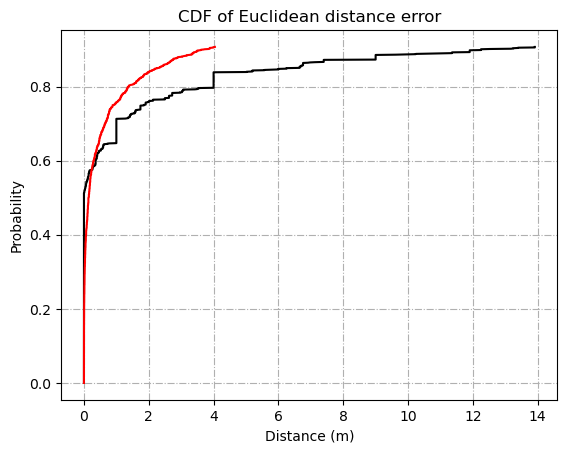

In [110]:
ldistx1=df_comp.ldist.iloc[4]
ldistx2=df_comp.ldist.iloc[5]
probi1= 1. * np.arange(len(ldistx1))/(len(ldistx1) - 1)
probi2= 1. * np.arange(len(ldistx2))/(len(ldistx2) - 1)
fig, ax = plt.subplots()
lg1, = ax.plot(ldistx1[0:1300], probi1[0:1300], color='black')
lg2, = ax.plot(ldistx2[0:1300], probi2[0:1300], color='red')
plt.title('CDF of Euclidean distance error')
plt.xlabel('Distance (m)')
plt.ylabel('Probability')
plt.grid(True)
gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

#plt.savefig('Figure_CDF_error.png', dpi=300)
plt.show()
plt.close()

In [ ]:
#######################################